# CKA similarity between layers of a transformer

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
from functools import partial
from warnings import warn
from typing import List, Dict
import matplotlib.pyplot as plt
from torch_cka.utils import add_colorbar


class CKA:
    def __init__(self,
                 model1: nn.Module,
                 model2: nn.Module,
                 model1_name: str = None,
                 model2_name: str = None,
                 model1_layers: List[str] = None,
                 model2_layers: List[str] = None,
                 device: str ='cpu'):
        """

        :param model1: (nn.Module) Neural Network 1
        :param model2: (nn.Module) Neural Network 2
        :param model1_name: (str) Name of model 1
        :param model2_name: (str) Name of model 2
        :param model1_layers: (List) List of layers to extract features from
        :param model2_layers: (List) List of layers to extract features from
        :param device: Device to run the model
        """

        self.model1 = model1
        self.model2 = model2

        self.device = device

        self.model1_info = {}
        self.model2_info = {}

        if model1_name is None:
            self.model1_info['Name'] = model1.__repr__().split('(')[0]
        else:
            self.model1_info['Name'] = model1_name

        if model2_name is None:
            self.model2_info['Name'] = model2.__repr__().split('(')[0]
        else:
            self.model2_info['Name'] = model2_name

        if self.model1_info['Name'] == self.model2_info['Name']:
            warn(f"Both model have identical names - {self.model2_info['Name']}. " \
                 "It may cause confusion when interpreting the results. " \
                 "Consider giving unique names to the models :)")

        self.model1_info['Layers'] = []
        self.model2_info['Layers'] = []

        self.model1_features = {}
        self.model2_features = {}

        if len(list(model1.modules())) > 150 and model1_layers is None:
            warn("Model 1 seems to have a lot of layers. " \
                 "Consider giving a list of layers whose features you are concerned with " \
                 "through the 'model1_layers' parameter. Your CPU/GPU will thank you :)")

        self.model1_layers = model1_layers

        if len(list(model2.modules())) > 150 and model2_layers is None:
            warn("Model 2 seems to have a lot of layers. " \
                 "Consider giving a list of layers whose features you are concerned with " \
                 "through the 'model2_layers' parameter. Your CPU/GPU will thank you :)")

        self.model2_layers = model2_layers

        self._insert_hooks()
        self.model1 = self.model1.to(self.device)
        self.model2 = self.model2.to(self.device)

        self.model1.eval()
        self.model2.eval()

    def _log_layer(self,
                   model: str,
                   name: str,
                   layer: nn.Module,
                   inp: torch.Tensor,
                   out: torch.Tensor):

        if model == "model1":
            self.model1_features[name] = out

        elif model == "model2":
            self.model2_features[name] = out

        else:
            raise RuntimeError("Unknown model name for _log_layer.")

    def _insert_hooks(self):
        # Model 1
        for name, layer in self.model1.named_modules():
            if self.model1_layers is not None:
                if name in self.model1_layers:
                    self.model1_info['Layers'] += [name]
                    layer.register_forward_hook(partial(self._log_layer, "model1", name))
            else:
                self.model1_info['Layers'] += [name]
                layer.register_forward_hook(partial(self._log_layer, "model1", name))

        # Model 2
        for name, layer in self.model2.named_modules():
            if self.model2_layers is not None:
                if name in self.model2_layers:
                    self.model2_info['Layers'] += [name]
                    layer.register_forward_hook(partial(self._log_layer, "model2", name))
            else:

                self.model2_info['Layers'] += [name]
                layer.register_forward_hook(partial(self._log_layer, "model2", name))

    def _HSIC(self, K, L):
        """
        Computes the unbiased estimate of HSIC metric.

        Reference: https://arxiv.org/pdf/2010.15327.pdf Eq (3)
        """
        N = K.shape[0]
        ones = torch.ones(N, 1).to(self.device)
        result = torch.trace(K @ L)
        result += ((ones.t() @ K @ ones @ ones.t() @ L @ ones) / ((N - 1) * (N - 2))).item()
        result -= ((ones.t() @ K @ L @ ones) * 2 / (N - 2)).item()
        return (1 / (N * (N - 3)) * result).item()

    def compare(self,
                dataloader1: DataLoader,
                dataloader2: DataLoader = None, 
                max_length: int = 1, 
                num_batches: int | None = None) -> None:
        """
        Computes the feature similarity between the models on the
        given datasets.
        :param dataloader1: (DataLoader)
        :param dataloader2: (DataLoader) If given, model 2 will run on this
                            dataset. (default = None)
        """

        if dataloader2 is None:
            warn("Dataloader for Model 2 is not given. Using the same dataloader for both models.")
            dataloader2 = dataloader1

        # self.model1_info['Dataset'] = dataloader1.dataset.__repr__().split('\n')[0]
        # self.model2_info['Dataset'] = dataloader2.dataset.__repr__().split('\n')[0]

        N = len(self.model1_layers) if self.model1_layers is not None else len(list(self.model1.modules()))
        M = len(self.model2_layers) if self.model2_layers is not None else len(list(self.model2.modules()))

        self.hsic_matrix = torch.zeros(N, M, 3)

        if num_batches is None:
            num_batches = min(len(dataloader1), len(dataloader1))

        for input_dict1, input_dict2 in tqdm(zip(dataloader1, dataloader2), desc="| Comparing features |", total=num_batches):
            input_ids1, attention_mask1 = input_dict1['input_ids'], input_dict1['attention_mask']
            input_ids2, attention_mask2 = input_dict2['input_ids'], input_dict2['attention_mask']

            self.model1_features = {}
            self.model2_features = {}
            _ = self.model1(input_ids=input_ids1.to(self.device), attention_mask=attention_mask1.to(self.device))#, max_length=max_length)
            _ = self.model2(input_ids=input_ids2.to(self.device), attention_mask=attention_mask2.to(self.device))#, max_length=max_length)

            for i, (name1, feat1) in enumerate(self.model1_features.items()):
                X = feat1.flatten(1)
                K = X @ X.t()
                K.fill_diagonal_(0.0)
                self.hsic_matrix[i, :, 0] += self._HSIC(K, K) / num_batches

                for j, (name2, feat2) in enumerate(self.model2_features.items()):
                    Y = feat2.flatten(1)
                    L = Y @ Y.t()
                    L.fill_diagonal_(0)
                    assert K.shape == L.shape, f"Feature shape mistach! {K.shape}, {L.shape}"

                    self.hsic_matrix[i, j, 1] += self._HSIC(K, L) / num_batches
                    self.hsic_matrix[i, j, 2] += self._HSIC(L, L) / num_batches

        self.hsic_matrix = self.hsic_matrix[:, :, 1] / (self.hsic_matrix[:, :, 0].sqrt() *
                                                        self.hsic_matrix[:, :, 2].sqrt())

        assert not torch.isnan(self.hsic_matrix).any(), "HSIC computation resulted in NANs"

    def export(self) -> Dict:
        """
        Exports the CKA data along with the respective model layer names.
        :return:
        """
        return {
            "model1_name": self.model1_info['Name'],
            "model2_name": self.model2_info['Name'],
            "CKA": self.hsic_matrix,
            "model1_layers": self.model1_info['Layers'],
            "model2_layers": self.model2_info['Layers'],
            "dataset1_name": self.model1_info['Dataset'],
            "dataset2_name": self.model2_info['Dataset'],

        }

    def plot_results(self,
                     save_path: str = None,
                     title: str = None):
        fig, ax = plt.subplots()
        im = ax.imshow(self.hsic_matrix, origin='lower', cmap='magma')
        ax.set_xlabel(f"Layers {self.model2_info['Name']}", fontsize=15)
        ax.set_ylabel(f"Layers {self.model1_info['Name']}", fontsize=15)

        if title is not None:
            ax.set_title(f"{title}", fontsize=18)
        else:
            ax.set_title(f"{self.model1_info['Name']} vs {self.model2_info['Name']}", fontsize=18)

        add_colorbar(im)
        plt.tight_layout()

        if save_path is not None:
            plt.savefig(save_path, dpi=300)

        plt.show()

In [44]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
from functools import partial
from warnings import warn
from typing import List, Dict
import matplotlib.pyplot as plt
from torch_cka.utils import add_colorbar


class CKA:
    def __init__(self,
                 model1: nn.Module,
                 model2: nn.Module,
                 model1_name: str = None,
                 model2_name: str = None,
                 model1_layers: List[str] = None,
                 model2_layers: List[str] = None,
                 device: str ='cpu'):
        """

        :param model1: (nn.Module) Neural Network 1
        :param model2: (nn.Module) Neural Network 2
        :param model1_name: (str) Name of model 1
        :param model2_name: (str) Name of model 2
        :param model1_layers: (List) List of layers to extract features from
        :param model2_layers: (List) List of layers to extract features from
        :param device: Device to run the model
        """

        self.model1 = model1
        self.model2 = model2

        self.device = device

        self.model1_info = {}
        self.model2_info = {}

        if model1_name is None:
            self.model1_info['Name'] = model1.__repr__().split('(')[0]
        else:
            self.model1_info['Name'] = model1_name

        if model2_name is None:
            self.model2_info['Name'] = model2.__repr__().split('(')[0]
        else:
            self.model2_info['Name'] = model2_name

        if self.model1_info['Name'] == self.model2_info['Name']:
            warn(f"Both model have identical names - {self.model2_info['Name']}. " \
                 "It may cause confusion when interpreting the results. " \
                 "Consider giving unique names to the models :)")

        self.model1_info['Layers'] = []
        self.model2_info['Layers'] = []

        self.model1_features = {}
        self.model2_features = {}

        if len(list(model1.modules())) > 150 and model1_layers is None:
            warn("Model 1 seems to have a lot of layers. " \
                 "Consider giving a list of layers whose features you are concerned with " \
                 "through the 'model1_layers' parameter. Your CPU/GPU will thank you :)")

        self.model1_layers = model1_layers

        if len(list(model2.modules())) > 150 and model2_layers is None:
            warn("Model 2 seems to have a lot of layers. " \
                 "Consider giving a list of layers whose features you are concerned with " \
                 "through the 'model2_layers' parameter. Your CPU/GPU will thank you :)")

        self.model2_layers = model2_layers

        self._insert_hooks()
        self.model1 = self.model1.to(self.device)
        self.model2 = self.model2.to(self.device)

        self.model1.eval()
        self.model2.eval()

    def _log_layer(self,
                   model: str,
                   name: str,
                   layer: nn.Module,
                   inp: torch.Tensor,
                   out: torch.Tensor):
        if model == "model1":
            self.model1_features[name] = out

        elif model == "model2":
            self.model2_features[name] = out

        else:
            raise RuntimeError("Unknown model name for _log_layer.")

    def _insert_hooks(self):
        # Model 1
        for name, layer in self.model1.named_modules():
            if self.model1_layers is not None:
                if name in self.model1_layers:
                    self.model1_info['Layers'] += [name]
                    layer.register_forward_hook(partial(self._log_layer, "model1", name))
            else:
                self.model1_info['Layers'] += [name]
                layer.register_forward_hook(partial(self._log_layer, "model1", name))

        # Model 2
        for name, layer in self.model2.named_modules():
            if self.model2_layers is not None:
                if name in self.model2_layers:
                    self.model2_info['Layers'] += [name]
                    layer.register_forward_hook(partial(self._log_layer, "model2", name))
            else:

                self.model2_info['Layers'] += [name]
                layer.register_forward_hook(partial(self._log_layer, "model2", name))

    def _HSIC(self, K, L):
        """
        Computes the unbiased estimate of HSIC metric.

        Reference: https://arxiv.org/pdf/2010.15327.pdf Eq (3)
        """
        N = K.shape[0]
        ones = torch.ones(N, 1).to(self.device)
        result = torch.trace(K @ L)
        result += ((ones.t() @ K @ ones @ ones.t() @ L @ ones) / ((N - 1) * (N - 2))).item()
        result -= ((ones.t() @ K @ L @ ones) * 2 / (N - 2)).item()
        return (1 / (N * (N - 3)) * result).item()

    def compare(self,
                dataloader1: DataLoader,
                dataloader2: DataLoader = None, 
                max_length: int = 1, 
                num_batches: int | None = None) -> None:
        """
        Computes the feature similarity between the models on the
        given datasets.
        :param dataloader1: (DataLoader)
        :param dataloader2: (DataLoader) If given, model 2 will run on this
                            dataset. (default = None)
        """

        if dataloader2 is None:
            warn("Dataloader for Model 2 is not given. Using the same dataloader for both models.")
            dataloader2 = dataloader1

        # self.model1_info['Dataset'] = dataloader1.dataset.__repr__().split('\n')[0]
        # self.model2_info['Dataset'] = dataloader2.dataset.__repr__().split('\n')[0]

        N = len(self.model1_layers) if self.model1_layers is not None else len(list(self.model1.modules()))
        M = len(self.model2_layers) if self.model2_layers is not None else len(list(self.model2.modules()))

        self.hsic_matrix = torch.zeros(N, M, 3)

        if num_batches is None:
            num_batches = min(len(dataloader1), len(dataloader1))

        for input_dict1, input_dict2 in tqdm(zip(dataloader1, dataloader2), desc="| Comparing features |", total=num_batches):
            input_ids1, attention_mask1 = input_dict1['input_ids'], input_dict1['attention_mask']
            input_ids2, attention_mask2 = input_dict2['input_ids'], input_dict2['attention_mask']

            self.model1_features = {}
            self.model2_features = {}
            _ = self.model1.generate(input_ids=input_ids1.to(self.device), attention_mask=attention_mask1.to(self.device), max_length=max_length)
            _ = self.model2.generate(input_ids=input_ids2.to(self.device), attention_mask=attention_mask2.to(self.device), max_length=max_length)

            for i, (name1, feat1) in enumerate(self.model1_features.items()):
                X = feat1.flatten(1)
                K = X @ X.t()
                K.fill_diagonal_(0.0)
                self.hsic_matrix[i, :, 0] += self._HSIC(K, K) / num_batches

                for j, (name2, feat2) in enumerate(self.model2_features.items()):
                    Y = feat2.flatten(1)
                    L = Y @ Y.t()
                    L.fill_diagonal_(0)
                    assert K.shape == L.shape, f"Feature shape mistach! {K.shape}, {L.shape}"

                    self.hsic_matrix[i, j, 1] += self._HSIC(K, L) / num_batches
                    self.hsic_matrix[i, j, 2] += self._HSIC(L, L) / num_batches

        self.hsic_matrix = self.hsic_matrix[:, :, 1] / (self.hsic_matrix[:, :, 0].sqrt() *
                                                        self.hsic_matrix[:, :, 2].sqrt())

        assert not torch.isnan(self.hsic_matrix).any(), "HSIC computation resulted in NANs"

    def export(self) -> Dict:
        """
        Exports the CKA data along with the respective model layer names.
        :return:
        """
        return {
            "model1_name": self.model1_info['Name'],
            "model2_name": self.model2_info['Name'],
            "CKA": self.hsic_matrix,
            "model1_layers": self.model1_info['Layers'],
            "model2_layers": self.model2_info['Layers'],
            "dataset1_name": self.model1_info['Dataset'],
            "dataset2_name": self.model2_info['Dataset'],

        }

    def plot_results(self,
                     save_path: str = None,
                     title: str = None):
        fig, ax = plt.subplots()
        im = ax.imshow(self.hsic_matrix, origin='lower', cmap='magma')
        ax.set_xlabel(f"Layers {self.model2_info['Name']}", fontsize=15)
        ax.set_ylabel(f"Layers {self.model1_info['Name']}", fontsize=15)

        if title is not None:
            ax.set_title(f"{title}", fontsize=18)
        else:
            ax.set_title(f"{self.model1_info['Name']} vs {self.model2_info['Name']}", fontsize=18)

        add_colorbar(im)
        plt.tight_layout()

        if save_path is not None:
            plt.savefig(save_path, dpi=300)

        plt.show()

In [2]:
import torch
import re  
from torch import nn 
from transformers import T5Tokenizer, T5ForConditionalGeneration
from datasets import load_dataset
from torch.utils.data import DataLoader

/home/kacperwyrwal/miniconda3/envs/honours_project/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load in T5 small 
tokenizer = T5Tokenizer.from_pretrained('t5-small')
model = T5ForConditionalGeneration.from_pretrained('t5-small')

In [4]:
# Load in the GLUE data
dataset = load_dataset('glue', 'mrpc')

# Tokenize the data
def tokenize(batch):
    return tokenizer(batch['sentence1'], padding='max_length', truncation=True)

dataset = dataset.map(tokenize, batched=True, batch_size=len(dataset))
dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

Reusing dataset glue (/home/kacperwyrwal/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
100%|██████████| 3/3 [00:00<00:00, 135.65it/s]
Loading cached processed dataset at /home/kacperwyrwal/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-c4bf414fff471189.arrow
Loading cached processed dataset at /home/kacperwyrwal/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-785eb0bcb4839f23.arrow
Loading cached processed dataset at /home/kacperwyrwal/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-42cd2687f56420a6.arrow


In [57]:
# Convert the dataset into a PyTorch DataLoader.
def hf_dataset_to_dataloader(dataset, batch_size=64, drop_last=True):
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size, 
        drop_last=drop_last
    )
    return dataloader, len(dataset) // batch_size + (not drop_last)

dataloader, num_batches = hf_dataset_to_dataloader(dataset['test'])

In [6]:
def match_module_names(model: nn.Module, pattern: re.Pattern | str) -> list[str]: 
    if isinstance(pattern, str): 
        pattern = re.compile(pattern)
    return [name for name, _ in model.named_modules() if pattern.match(name)]

In [28]:
pattern_q = re.compile(r'block\.\d+\.layer\.\d+\.SelfAttention\.q')
pattern_fc = re.compile(r'block\.\d+\.layer\.\d+\.DenseReluDense\.(wi|wo)')
pattern_q_model = re.compile(r'encoder\.block\.\d+\.layer\.\d+\.SelfAttention\.q')
pattern_fc_model = re.compile(r'encoder\.block\.\d+\.layer\.\d+\.DenseReluDense\.(wi|wo)')
model_layers = match_module_names(model, pattern_fc_model)
model_layers

['encoder.block.0.layer.1.DenseReluDense.wi',
 'encoder.block.0.layer.1.DenseReluDense.wo',
 'encoder.block.1.layer.1.DenseReluDense.wi',
 'encoder.block.1.layer.1.DenseReluDense.wo',
 'encoder.block.2.layer.1.DenseReluDense.wi',
 'encoder.block.2.layer.1.DenseReluDense.wo',
 'encoder.block.3.layer.1.DenseReluDense.wi',
 'encoder.block.3.layer.1.DenseReluDense.wo',
 'encoder.block.4.layer.1.DenseReluDense.wi',
 'encoder.block.4.layer.1.DenseReluDense.wo',
 'encoder.block.5.layer.1.DenseReluDense.wi',
 'encoder.block.5.layer.1.DenseReluDense.wo']

In [42]:
for input_dict in dataloader: 
    input_ids, attention_mask = input_dict['input_ids'], input_dict['attention_mask']
    break

# model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=10)
print(tokenizer.batch_decode(model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=50))[-1])
print(tokenizer.batch_decode(input_ids)[-1])

<pad> <extra_id_0> said Friday. A Washington County man may have the countys first human case of West Nile virus.</s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
A Washington County man may have the countys first human case of West Nile virus, the health department said Friday.</s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>

In [8]:

dataloader, num_batches = hf_dataset_to_dataloader(dataset['test'].select(range(128)), batch_size=8)
CKA(model, model, model1_layers=model_layers, model2_layers=model_layers).compare(dataloader, dataloader, 2, num_batches)

/tmp/ipykernel_179838/989203279.py:51: UserWarning: Both model have identical names - T5Stack. It may cause confusion when interpreting the results. Consider giving unique names to the models :)
  warn(f"Both model have identical names - {self.model2_info['Name']}. " \
| Comparing features |:   0%|          | 0/17 [00:00<?, ?it/s]

| Comparing features |:  94%|█████████▍| 16/17 [00:34<00:02,  2.17s/it]


/tmp/ipykernel_179838/3597831672.py:51: UserWarning: Both model have identical names - T5 small. It may cause confusion when interpreting the results. Consider giving unique names to the models :)
  warn(f"Both model have identical names - {self.model2_info['Name']}. " \
| Comparing features |:   0%|          | 0/8 [00:00<?, ?it/s]

| Comparing features |: 100%|██████████| 8/8 [00:16<00:00,  2.11s/it]


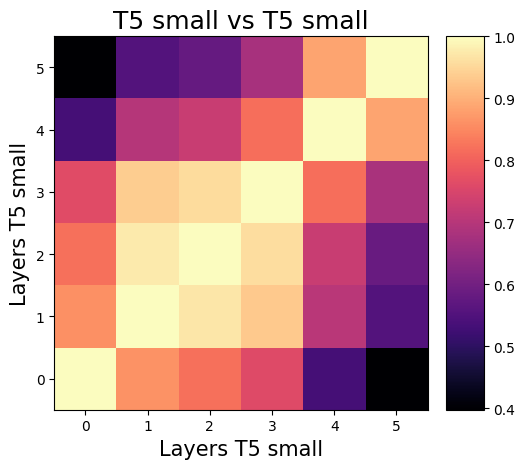

In [22]:
def run_cka(
    model: torch.nn.Module, 
    dataloader: DataLoader, 
    model_name: str | None = None, 
    model_layers: list[str] | None = None, 
    device: str = 'cpu', 
    max_length: int = 1
) -> CKA: 
    """
    Runs CKA for every pair of layers in the model and plots the results as a heatmap. 
    """
    if model_name is None: 
        model_name = model.__class__.__name__
    cka = CKA(
        model1=model, 
        model2=model,
        model1_name=model_name,
        model2_name=model_name,   
        model1_layers=model_layers,
        model2_layers=model_layers,
        device=device,
    )
    cka.compare(dataloader1=dataloader, dataloader2=dataloader, max_length=max_length)
    cka.plot_results()
    return cka


dataloader, num_batches = hf_dataset_to_dataloader(dataset['test'].select(range(64)), batch_size=8)

In [52]:
ckas[0].model1_features

{'encoder.block.0.layer.1.DenseReluDense.wi': tensor([[[-4.9401e+00, -6.2327e+00,  1.2214e+00,  ..., -7.1443e+00,
           -2.7689e+00, -4.6845e+00],
          [ 1.1531e+00, -8.0873e+00, -5.0663e+00,  ..., -7.6373e+00,
           -4.6464e+00, -9.6894e+00],
          [-4.5543e+00, -1.2073e+01,  7.7265e-01,  ..., -7.3637e+00,
           -8.4217e+00, -6.8092e+00],
          ...,
          [-1.5711e+00,  2.0086e-01, -5.9855e-03,  ..., -1.1434e+01,
            3.1810e+00, -4.3244e+00],
          [-1.5711e+00,  2.0086e-01, -5.9855e-03,  ..., -1.1434e+01,
            3.1810e+00, -4.3244e+00],
          [-1.5711e+00,  2.0086e-01, -5.9855e-03,  ..., -1.1434e+01,
            3.1810e+00, -4.3244e+00]],
 
         [[-8.7536e+00, -1.4306e+01,  1.8328e-01,  ..., -4.9452e+00,
           -5.5240e+00, -7.0614e+00],
          [-1.0809e+01, -1.2135e+01, -7.0732e+00,  ..., -4.5719e+00,
           -2.5770e+00, -8.1818e+00],
          [-1.0933e+01, -1.4787e+01,  4.2137e-01,  ..., -6.0407e+00,
           -

In [61]:
model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=10)

Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging


tensor([[    0,  4794,   299,  1703,     6,  5752,  2699,  5502,     3,     6],
        [    0, 32099,     3,    31,     7,   192,  2015,  1510,  8910,   243],
        [    0,     3, 17152,     8,  2822,  1166,     7,    21, 14326,  4330],
        [    0, 32099,  1771,    11,    47,  1644,    12,  1560,  5775,   590],
        [    0,   316, 14533,     3,   547,   311,  2736,    40,  3930,    67],
        [    0,   316,     3, 19691,   688, 15332,   319,  1159,     3, 23276],
        [    0,  1761,     3, 10205,  7512,    15,  2415,     9,    99,    15],
        [    0, 32099,   243,  1701,     3,     5,    71,  2386,  1334,   388]])

/tmp/ipykernel_179838/2199203350.py:51: UserWarning: Both model have identical names - T5 small. It may cause confusion when interpreting the results. Consider giving unique names to the models :)
  warn(f"Both model have identical names - {self.model2_info['Name']}. " \
| Comparing features |:   0%|          | 0/1 [00:00<?, ?it/s]

Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging


Input length of decoder_input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging


Input length of decoder_input_ids is 1, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
| Comparing features |: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]

Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging


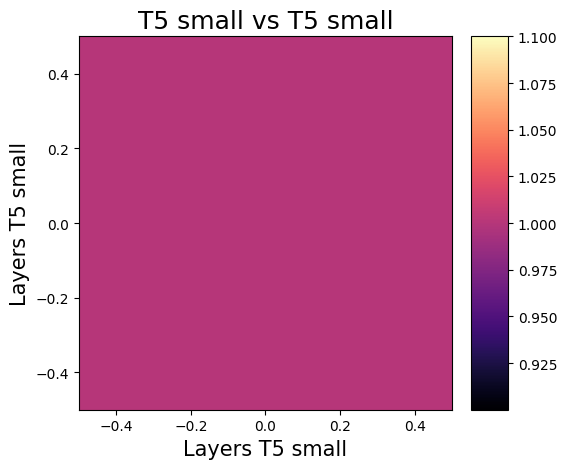

| Comparing features |:   0%|          | 0/1 [00:00<?, ?it/s]

Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging


| Comparing features |: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


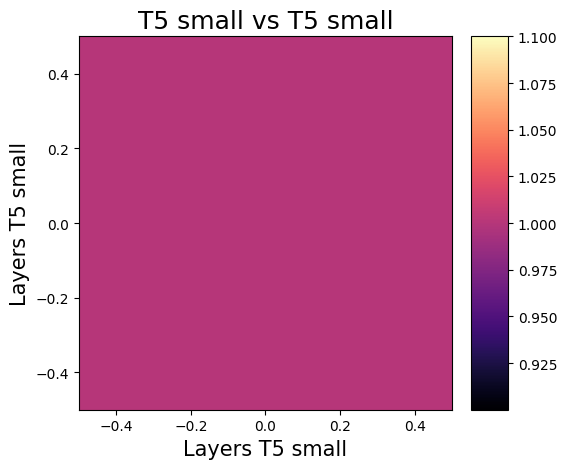

| Comparing features |:   0%|          | 0/1 [00:00<?, ?it/s]

Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging
Logging


| Comparing features |: 100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


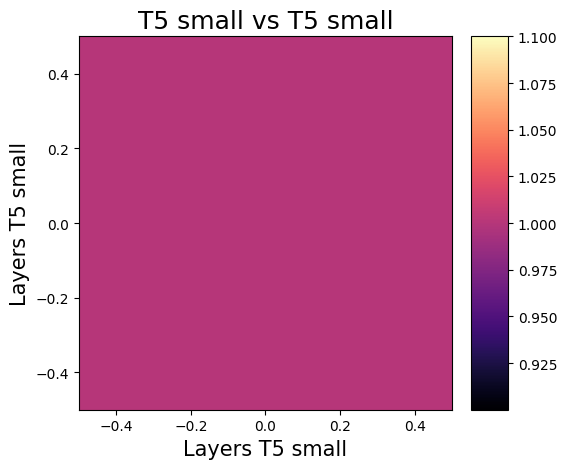

In [58]:
ckas = []
dataloader, num_batches = hf_dataset_to_dataloader(dataset['test'].select(range(4)), batch_size=4)
for max_length in [1, 10, 50]: 
    ckas.append(run_cka(model, dataloader, model_name="T5 small", model_layers=[model_layers[0]], max_length=max_length))

In [30]:
ckas[1].model1_features

{'encoder.block.0.layer.1.DenseReluDense.wi': tensor([[[ -3.8402,  -3.7574,  -7.4154,  ...,  -7.9979,  -4.4502,  -7.8363],
          [ -6.9102, -11.4260,  -3.3313,  ...,  -1.9230,   2.6349,  -3.7973],
          [ -3.1572,  -8.4965,   0.0832,  ...,  -4.1477,  -2.8006, -12.6792],
          ...,
          [ -1.5758,   0.6845,  -0.2528,  ..., -10.6788,   3.0866,  -4.2611],
          [ -1.5758,   0.6845,  -0.2528,  ..., -10.6788,   3.0866,  -4.2611],
          [ -1.5758,   0.6845,  -0.2528,  ..., -10.6788,   3.0866,  -4.2611]],
 
         [[ -4.3424,  -9.8444,   1.9510,  ...,  -7.1581,  -3.2593,  -6.8585],
          [ -5.6663,  -8.3314,  -1.0265,  ...,  -6.2376,  -1.0283,  -7.7184],
          [ -3.1097,  -5.5053,   0.6286,  ...,  -7.6086,  -4.3315,  -2.6617],
          ...,
          [ -3.0959,   0.7068,   0.1763,  ..., -10.4725,   3.0394,  -3.4158],
          [ -3.0959,   0.7068,   0.1763,  ..., -10.4725,   3.0394,  -3.4158],
          [ -3.0959,   0.7068,   0.1763,  ..., -10.4725,   3.039

In [31]:
ckas[0].model1_features

{'encoder.block.0.layer.1.DenseReluDense.wi': tensor([[[ -3.8402,  -3.7574,  -7.4154,  ...,  -7.9979,  -4.4502,  -7.8363],
          [ -6.9102, -11.4260,  -3.3313,  ...,  -1.9230,   2.6349,  -3.7973],
          [ -3.1572,  -8.4965,   0.0832,  ...,  -4.1477,  -2.8006, -12.6792],
          ...,
          [ -1.5758,   0.6845,  -0.2528,  ..., -10.6788,   3.0866,  -4.2611],
          [ -1.5758,   0.6845,  -0.2528,  ..., -10.6788,   3.0866,  -4.2611],
          [ -1.5758,   0.6845,  -0.2528,  ..., -10.6788,   3.0866,  -4.2611]],
 
         [[ -4.3424,  -9.8444,   1.9510,  ...,  -7.1581,  -3.2593,  -6.8585],
          [ -5.6663,  -8.3314,  -1.0265,  ...,  -6.2376,  -1.0283,  -7.7184],
          [ -3.1097,  -5.5053,   0.6286,  ...,  -7.6086,  -4.3315,  -2.6617],
          ...,
          [ -3.0959,   0.7068,   0.1763,  ..., -10.4725,   3.0394,  -3.4158],
          [ -3.0959,   0.7068,   0.1763,  ..., -10.4725,   3.0394,  -3.4158],
          [ -3.0959,   0.7068,   0.1763,  ..., -10.4725,   3.039